# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

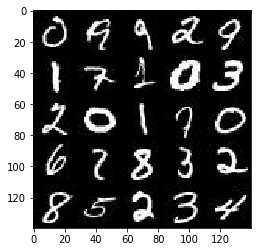

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

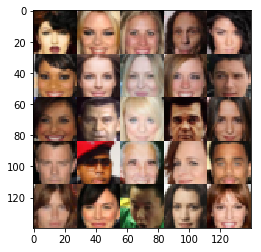

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_height, image_width, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
# define leaky_relu
def leaky_relu(x, alpha=0.1):
    return tf.maximum(x, alpha * x)

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        conv_1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu_1 = leaky_relu(conv_1)
        
        conv_2 = tf.layers.conv2d(relu_1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn_2 = tf.layers.batch_normalization(conv_2, training=True)
        relu_2 = leaky_relu(bn_2)
        
        flatten = tf.reshape(relu_2, (-1, 7*7*128))
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        ly_1 = tf.layers.dense(z, 7*7*512)
        
        ly_1 = tf.reshape(ly_1, (-1, 7, 7, 512))
        ly_1 = tf.layers.batch_normalization(ly_1, training=is_train)
        ly_1 = leaky_relu(ly_1)
        
        ly_2 = tf.layers.conv2d_transpose(ly_1, 64, 5, strides=2, padding='same')
        ly_2 = tf.layers.batch_normalization(ly_2, training=is_train)
        ly_2 = leaky_relu(ly_2)
        
        logits = tf.layers.conv2d_transpose(ly_2, out_channel_dim, 5, strides=2, padding='same')
        out =tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.1
    
    gener = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(gener, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    d_vars = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]
    g_vars = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    count = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                count += 1
                
                n_images=len(batch_images)
                batch_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
                
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if count%10 == 0:
                    d_train_loss = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    g_train_loss = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i, epoch_count-1),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss), "Generator Loss: {:.4f}".format(g_train_loss))
                if count%128 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/1... Discriminator Loss: 1.4590... Generator Loss: 0.5787
Epoch 0/1... Discriminator Loss: 1.5055... Generator Loss: 0.7058
Epoch 0/1... Discriminator Loss: 1.3038... Generator Loss: 1.0104
Epoch 0/1... Discriminator Loss: 1.2899... Generator Loss: 1.0006
Epoch 0/1... Discriminator Loss: 1.2182... Generator Loss: 0.8243
Epoch 0/1... Discriminator Loss: 1.3372... Generator Loss: 1.5689
Epoch 0/1... Discriminator Loss: 1.2720... Generator Loss: 1.4433
Epoch 0/1... Discriminator Loss: 1.0244... Generator Loss: 1.1448
Epoch 0/1... Discriminator Loss: 1.1082... Generator Loss: 0.8790
Epoch 0/1... Discriminator Loss: 1.0137... Generator Loss: 0.9849
Epoch 0/1... Discriminator Loss: 1.1484... Generator Loss: 1.4745
Epoch 0/1... Discriminator Loss: 0.9125... Generator Loss: 1.3521


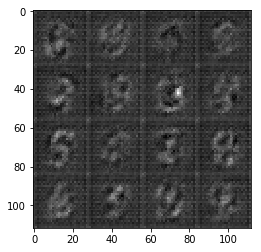

Epoch 0/1... Discriminator Loss: 0.8892... Generator Loss: 1.1512
Epoch 0/1... Discriminator Loss: 0.8309... Generator Loss: 1.7493
Epoch 0/1... Discriminator Loss: 0.8333... Generator Loss: 1.2898
Epoch 0/1... Discriminator Loss: 1.0851... Generator Loss: 1.7956
Epoch 0/1... Discriminator Loss: 0.7825... Generator Loss: 2.0946
Epoch 0/1... Discriminator Loss: 0.8179... Generator Loss: 1.3049
Epoch 0/1... Discriminator Loss: 0.7180... Generator Loss: 1.6582
Epoch 0/1... Discriminator Loss: 0.7628... Generator Loss: 1.2965
Epoch 0/1... Discriminator Loss: 0.7994... Generator Loss: 2.0949
Epoch 0/1... Discriminator Loss: 0.8291... Generator Loss: 1.3442
Epoch 0/1... Discriminator Loss: 0.9250... Generator Loss: 2.3023
Epoch 0/1... Discriminator Loss: 0.7451... Generator Loss: 2.1455
Epoch 0/1... Discriminator Loss: 0.7848... Generator Loss: 1.2600


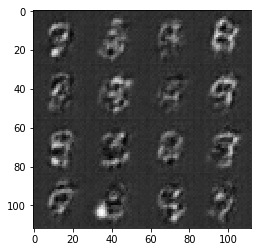

Epoch 0/1... Discriminator Loss: 0.7471... Generator Loss: 1.4476
Epoch 0/1... Discriminator Loss: 0.9068... Generator Loss: 0.8817
Epoch 0/1... Discriminator Loss: 0.7398... Generator Loss: 1.2817
Epoch 0/1... Discriminator Loss: 0.8932... Generator Loss: 2.6080
Epoch 0/1... Discriminator Loss: 0.7501... Generator Loss: 1.3696
Epoch 0/1... Discriminator Loss: 0.6077... Generator Loss: 1.7232
Epoch 0/1... Discriminator Loss: 0.6611... Generator Loss: 1.7691
Epoch 0/1... Discriminator Loss: 0.8298... Generator Loss: 1.0851
Epoch 0/1... Discriminator Loss: 1.0510... Generator Loss: 0.7454
Epoch 0/1... Discriminator Loss: 0.7588... Generator Loss: 2.2550
Epoch 0/1... Discriminator Loss: 0.7270... Generator Loss: 1.3132
Epoch 0/1... Discriminator Loss: 0.6493... Generator Loss: 1.9748
Epoch 0/1... Discriminator Loss: 1.1751... Generator Loss: 0.6380


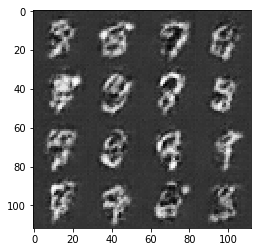

Epoch 0/1... Discriminator Loss: 0.7307... Generator Loss: 1.2820
Epoch 0/1... Discriminator Loss: 0.7079... Generator Loss: 1.3503
Epoch 0/1... Discriminator Loss: 0.7348... Generator Loss: 1.3051
Epoch 0/1... Discriminator Loss: 0.7448... Generator Loss: 1.3316
Epoch 0/1... Discriminator Loss: 0.6584... Generator Loss: 2.4746
Epoch 0/1... Discriminator Loss: 0.6736... Generator Loss: 2.5216
Epoch 0/1... Discriminator Loss: 0.7713... Generator Loss: 1.1798
Epoch 0/1... Discriminator Loss: 0.6085... Generator Loss: 2.6747
Epoch 1/1... Discriminator Loss: 0.6542... Generator Loss: 1.5387
Epoch 1/1... Discriminator Loss: 0.8643... Generator Loss: 1.0135
Epoch 1/1... Discriminator Loss: 0.7344... Generator Loss: 2.6365
Epoch 1/1... Discriminator Loss: 0.5958... Generator Loss: 2.4587
Epoch 1/1... Discriminator Loss: 0.6406... Generator Loss: 1.6695


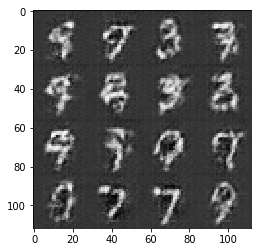

Epoch 1/1... Discriminator Loss: 0.7793... Generator Loss: 2.8650
Epoch 1/1... Discriminator Loss: 0.5821... Generator Loss: 1.7706
Epoch 1/1... Discriminator Loss: 0.5952... Generator Loss: 2.3781
Epoch 1/1... Discriminator Loss: 0.9059... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 0.6693... Generator Loss: 1.4991
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 0.7419... Generator Loss: 1.2540
Epoch 1/1... Discriminator Loss: 0.6678... Generator Loss: 1.4756
Epoch 1/1... Discriminator Loss: 0.6303... Generator Loss: 2.5391
Epoch 1/1... Discriminator Loss: 0.6716... Generator Loss: 1.5250
Epoch 1/1... Discriminator Loss: 0.5797... Generator Loss: 2.1577
Epoch 1/1... Discriminator Loss: 0.6908... Generator Loss: 2.1448
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 0.9604


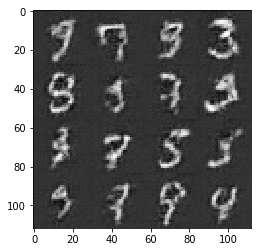

Epoch 1/1... Discriminator Loss: 0.7590... Generator Loss: 1.2197
Epoch 1/1... Discriminator Loss: 0.7790... Generator Loss: 1.2149
Epoch 1/1... Discriminator Loss: 0.6806... Generator Loss: 1.7683
Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 1.7950
Epoch 1/1... Discriminator Loss: 0.7532... Generator Loss: 1.2315
Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 2.9729
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 2.4869
Epoch 1/1... Discriminator Loss: 0.6704... Generator Loss: 1.8714
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 2.5750
Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 1.6185
Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 0.9762
Epoch 1/1... Discriminator Loss: 0.7320... Generator Loss: 1.5062


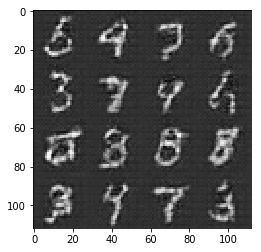

Epoch 1/1... Discriminator Loss: 0.6813... Generator Loss: 1.8294
Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 1.9850
Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 1.4817
Epoch 1/1... Discriminator Loss: 0.6209... Generator Loss: 2.5466
Epoch 1/1... Discriminator Loss: 0.6211... Generator Loss: 1.6381
Epoch 1/1... Discriminator Loss: 0.6652... Generator Loss: 2.0722
Epoch 1/1... Discriminator Loss: 0.6162... Generator Loss: 1.7984
Epoch 1/1... Discriminator Loss: 0.5720... Generator Loss: 1.8053
Epoch 1/1... Discriminator Loss: 0.7087... Generator Loss: 1.3190
Epoch 1/1... Discriminator Loss: 0.5378... Generator Loss: 2.3636
Epoch 1/1... Discriminator Loss: 0.5793... Generator Loss: 1.8227
Epoch 1/1... Discriminator Loss: 0.6379... Generator Loss: 1.6922
Epoch 1/1... Discriminator Loss: 0.5762... Generator Loss: 1.8401


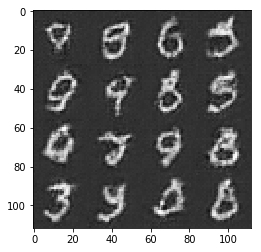

Epoch 1/1... Discriminator Loss: 0.7607... Generator Loss: 1.2119
Epoch 1/1... Discriminator Loss: 0.5480... Generator Loss: 2.2016
Epoch 1/1... Discriminator Loss: 0.7618... Generator Loss: 2.5715
Epoch 1/1... Discriminator Loss: 0.7128... Generator Loss: 1.7564


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/0... Discriminator Loss: 3.3309... Generator Loss: 0.0911
Epoch 0/0... Discriminator Loss: 2.5884... Generator Loss: 0.2975
Epoch 0/0... Discriminator Loss: 1.6965... Generator Loss: 0.6455
Epoch 0/0... Discriminator Loss: 1.6666... Generator Loss: 0.8158
Epoch 0/0... Discriminator Loss: 1.3062... Generator Loss: 1.0311
Epoch 0/0... Discriminator Loss: 1.2196... Generator Loss: 1.0044
Epoch 0/0... Discriminator Loss: 1.1309... Generator Loss: 1.0435
Epoch 0/0... Discriminator Loss: 1.1539... Generator Loss: 1.3876
Epoch 0/0... Discriminator Loss: 1.0647... Generator Loss: 0.9782
Epoch 0/0... Discriminator Loss: 1.0310... Generator Loss: 0.9415
Epoch 0/0... Discriminator Loss: 0.7903... Generator Loss: 1.9523
Epoch 0/0... Discriminator Loss: 1.0495... Generator Loss: 0.9480


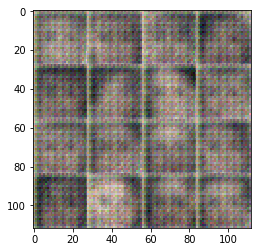

Epoch 0/0... Discriminator Loss: 1.3426... Generator Loss: 0.8072
Epoch 0/0... Discriminator Loss: 0.7414... Generator Loss: 2.0483
Epoch 0/0... Discriminator Loss: 1.2119... Generator Loss: 1.3182
Epoch 0/0... Discriminator Loss: 0.8880... Generator Loss: 1.9535
Epoch 0/0... Discriminator Loss: 1.0381... Generator Loss: 1.2309
Epoch 0/0... Discriminator Loss: 0.8347... Generator Loss: 1.7554
Epoch 0/0... Discriminator Loss: 1.0347... Generator Loss: 0.9053
Epoch 0/0... Discriminator Loss: 0.8336... Generator Loss: 1.7343
Epoch 0/0... Discriminator Loss: 0.7312... Generator Loss: 2.0273
Epoch 0/0... Discriminator Loss: 0.9261... Generator Loss: 0.9902
Epoch 0/0... Discriminator Loss: 0.7013... Generator Loss: 1.5994
Epoch 0/0... Discriminator Loss: 0.9128... Generator Loss: 2.4757
Epoch 0/0... Discriminator Loss: 0.7679... Generator Loss: 1.3806


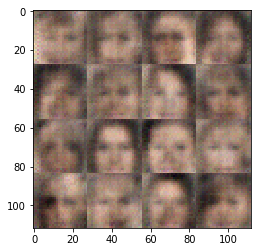

Epoch 0/0... Discriminator Loss: 1.1239... Generator Loss: 0.7389
Epoch 0/0... Discriminator Loss: 0.7159... Generator Loss: 2.2365
Epoch 0/0... Discriminator Loss: 0.7213... Generator Loss: 1.4981
Epoch 0/0... Discriminator Loss: 0.8608... Generator Loss: 1.7240
Epoch 0/0... Discriminator Loss: 0.7558... Generator Loss: 2.7781
Epoch 0/0... Discriminator Loss: 1.2383... Generator Loss: 4.0034
Epoch 0/0... Discriminator Loss: 1.1536... Generator Loss: 0.8608
Epoch 0/0... Discriminator Loss: 1.2845... Generator Loss: 0.9949
Epoch 0/0... Discriminator Loss: 0.8977... Generator Loss: 1.5451
Epoch 0/0... Discriminator Loss: 1.1757... Generator Loss: 0.8532
Epoch 0/0... Discriminator Loss: 1.0288... Generator Loss: 1.1963
Epoch 0/0... Discriminator Loss: 1.2445... Generator Loss: 0.9491
Epoch 0/0... Discriminator Loss: 1.3261... Generator Loss: 0.7142


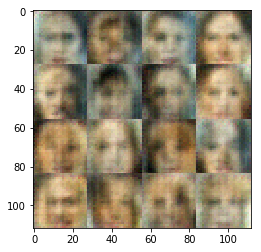

Epoch 0/0... Discriminator Loss: 1.2242... Generator Loss: 0.7316
Epoch 0/0... Discriminator Loss: 1.3013... Generator Loss: 0.9084
Epoch 0/0... Discriminator Loss: 0.9198... Generator Loss: 1.1220
Epoch 0/0... Discriminator Loss: 1.3940... Generator Loss: 0.4833
Epoch 0/0... Discriminator Loss: 1.1440... Generator Loss: 0.7647
Epoch 0/0... Discriminator Loss: 0.7995... Generator Loss: 1.5293
Epoch 0/0... Discriminator Loss: 0.7404... Generator Loss: 1.3415
Epoch 0/0... Discriminator Loss: 0.9219... Generator Loss: 0.9225
Epoch 0/0... Discriminator Loss: 0.8650... Generator Loss: 1.0477
Epoch 0/0... Discriminator Loss: 1.1450... Generator Loss: 0.6617
Epoch 0/0... Discriminator Loss: 1.1245... Generator Loss: 0.7153
Epoch 0/0... Discriminator Loss: 0.6093... Generator Loss: 2.8161
Epoch 0/0... Discriminator Loss: 0.7283... Generator Loss: 2.2825


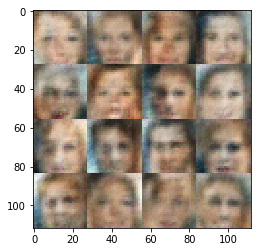

Epoch 0/0... Discriminator Loss: 0.5993... Generator Loss: 2.8000
Epoch 0/0... Discriminator Loss: 0.9600... Generator Loss: 2.3935
Epoch 0/0... Discriminator Loss: 0.8784... Generator Loss: 3.2681
Epoch 0/0... Discriminator Loss: 0.6904... Generator Loss: 2.9146
Epoch 0/0... Discriminator Loss: 0.8594... Generator Loss: 1.7841
Epoch 0/0... Discriminator Loss: 1.2032... Generator Loss: 0.5964
Epoch 0/0... Discriminator Loss: 0.9661... Generator Loss: 3.8020
Epoch 0/0... Discriminator Loss: 0.8940... Generator Loss: 1.0003
Epoch 0/0... Discriminator Loss: 1.0291... Generator Loss: 0.8191
Epoch 0/0... Discriminator Loss: 0.7019... Generator Loss: 2.7400
Epoch 0/0... Discriminator Loss: 0.5316... Generator Loss: 1.8490
Epoch 0/0... Discriminator Loss: 0.4463... Generator Loss: 3.0565
Epoch 0/0... Discriminator Loss: 0.6942... Generator Loss: 1.9567


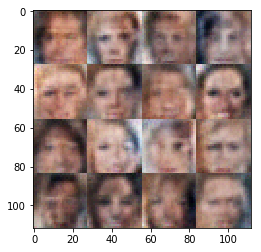

Epoch 0/0... Discriminator Loss: 0.6230... Generator Loss: 2.8657
Epoch 0/0... Discriminator Loss: 0.7431... Generator Loss: 3.5149
Epoch 0/0... Discriminator Loss: 1.0175... Generator Loss: 2.0467
Epoch 0/0... Discriminator Loss: 0.8934... Generator Loss: 0.9024
Epoch 0/0... Discriminator Loss: 0.5867... Generator Loss: 5.3968
Epoch 0/0... Discriminator Loss: 0.8193... Generator Loss: 1.9455
Epoch 0/0... Discriminator Loss: 0.5033... Generator Loss: 2.0738
Epoch 0/0... Discriminator Loss: 0.5085... Generator Loss: 2.3194
Epoch 0/0... Discriminator Loss: 1.0388... Generator Loss: 3.2792
Epoch 0/0... Discriminator Loss: 1.5583... Generator Loss: 0.3926
Epoch 0/0... Discriminator Loss: 0.5834... Generator Loss: 2.0893
Epoch 0/0... Discriminator Loss: 0.4917... Generator Loss: 3.0510


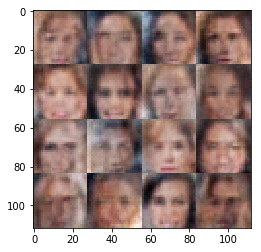

Epoch 0/0... Discriminator Loss: 0.9801... Generator Loss: 3.9677
Epoch 0/0... Discriminator Loss: 0.9408... Generator Loss: 1.2210
Epoch 0/0... Discriminator Loss: 1.5238... Generator Loss: 0.3994
Epoch 0/0... Discriminator Loss: 0.5961... Generator Loss: 1.7516
Epoch 0/0... Discriminator Loss: 0.5449... Generator Loss: 2.6653
Epoch 0/0... Discriminator Loss: 0.6044... Generator Loss: 3.5073
Epoch 0/0... Discriminator Loss: 0.5454... Generator Loss: 2.7510
Epoch 0/0... Discriminator Loss: 0.7109... Generator Loss: 2.0674
Epoch 0/0... Discriminator Loss: 0.7333... Generator Loss: 1.6191
Epoch 0/0... Discriminator Loss: 0.7944... Generator Loss: 1.0943
Epoch 0/0... Discriminator Loss: 0.5642... Generator Loss: 1.8039
Epoch 0/0... Discriminator Loss: 1.6364... Generator Loss: 0.3402
Epoch 0/0... Discriminator Loss: 0.8332... Generator Loss: 0.9771


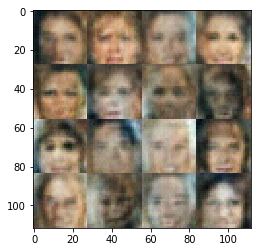

Epoch 0/0... Discriminator Loss: 0.4587... Generator Loss: 4.7547
Epoch 0/0... Discriminator Loss: 0.5472... Generator Loss: 2.5388
Epoch 0/0... Discriminator Loss: 0.6941... Generator Loss: 2.4912
Epoch 0/0... Discriminator Loss: 0.5974... Generator Loss: 3.6428
Epoch 0/0... Discriminator Loss: 0.5247... Generator Loss: 2.4026
Epoch 0/0... Discriminator Loss: 0.6708... Generator Loss: 1.8691
Epoch 0/0... Discriminator Loss: 0.6252... Generator Loss: 2.0045
Epoch 0/0... Discriminator Loss: 0.5311... Generator Loss: 2.5804
Epoch 0/0... Discriminator Loss: 0.5209... Generator Loss: 2.2239
Epoch 0/0... Discriminator Loss: 0.5866... Generator Loss: 1.7102
Epoch 0/0... Discriminator Loss: 0.4642... Generator Loss: 2.5950
Epoch 0/0... Discriminator Loss: 0.9869... Generator Loss: 0.7769
Epoch 0/0... Discriminator Loss: 1.3023... Generator Loss: 0.5238


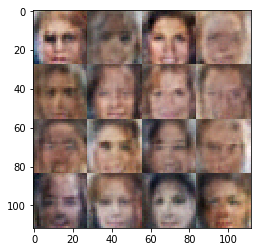

Epoch 0/0... Discriminator Loss: 0.7858... Generator Loss: 1.2848
Epoch 0/0... Discriminator Loss: 0.7793... Generator Loss: 3.6810
Epoch 0/0... Discriminator Loss: 0.5041... Generator Loss: 2.4719
Epoch 0/0... Discriminator Loss: 0.5670... Generator Loss: 1.9413
Epoch 0/0... Discriminator Loss: 0.6198... Generator Loss: 1.5316
Epoch 0/0... Discriminator Loss: 0.4433... Generator Loss: 2.6931
Epoch 0/0... Discriminator Loss: 0.4538... Generator Loss: 4.6619
Epoch 0/0... Discriminator Loss: 0.7773... Generator Loss: 1.2279
Epoch 0/0... Discriminator Loss: 0.5705... Generator Loss: 1.7203
Epoch 0/0... Discriminator Loss: 0.7694... Generator Loss: 1.1474
Epoch 0/0... Discriminator Loss: 0.5624... Generator Loss: 2.5595
Epoch 0/0... Discriminator Loss: 0.6191... Generator Loss: 1.7382
Epoch 0/0... Discriminator Loss: 2.6532... Generator Loss: 0.1169


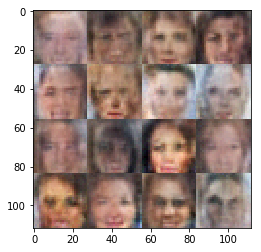

Epoch 0/0... Discriminator Loss: 0.5575... Generator Loss: 3.5050
Epoch 0/0... Discriminator Loss: 0.6152... Generator Loss: 3.5196
Epoch 0/0... Discriminator Loss: 0.6949... Generator Loss: 2.3580
Epoch 0/0... Discriminator Loss: 0.7838... Generator Loss: 4.2195
Epoch 0/0... Discriminator Loss: 0.5581... Generator Loss: 2.2833
Epoch 0/0... Discriminator Loss: 1.1166... Generator Loss: 0.6780
Epoch 0/0... Discriminator Loss: 1.1649... Generator Loss: 0.6450
Epoch 0/0... Discriminator Loss: 1.6900... Generator Loss: 0.3386
Epoch 0/0... Discriminator Loss: 0.7667... Generator Loss: 1.1831
Epoch 0/0... Discriminator Loss: 0.9473... Generator Loss: 0.9274
Epoch 0/0... Discriminator Loss: 0.8478... Generator Loss: 1.0008
Epoch 0/0... Discriminator Loss: 1.1684... Generator Loss: 0.6208
Epoch 0/0... Discriminator Loss: 1.5639... Generator Loss: 0.3850


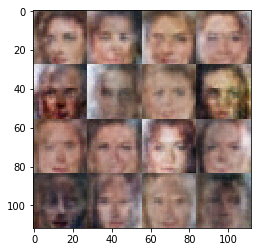

Epoch 0/0... Discriminator Loss: 1.0092... Generator Loss: 0.9922
Epoch 0/0... Discriminator Loss: 0.6688... Generator Loss: 1.7106
Epoch 0/0... Discriminator Loss: 0.8765... Generator Loss: 1.0340
Epoch 0/0... Discriminator Loss: 1.1688... Generator Loss: 0.6183
Epoch 0/0... Discriminator Loss: 0.9388... Generator Loss: 0.8541
Epoch 0/0... Discriminator Loss: 0.5519... Generator Loss: 1.7336
Epoch 0/0... Discriminator Loss: 0.6687... Generator Loss: 1.7702
Epoch 0/0... Discriminator Loss: 0.5157... Generator Loss: 2.2942
Epoch 0/0... Discriminator Loss: 0.5189... Generator Loss: 2.2673
Epoch 0/0... Discriminator Loss: 0.5104... Generator Loss: 2.0954
Epoch 0/0... Discriminator Loss: 0.5663... Generator Loss: 1.9168
Epoch 0/0... Discriminator Loss: 0.5141... Generator Loss: 5.2048


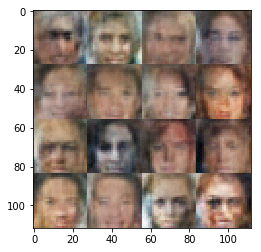

Epoch 0/0... Discriminator Loss: 0.4775... Generator Loss: 2.4375
Epoch 0/0... Discriminator Loss: 0.4684... Generator Loss: 3.5248
Epoch 0/0... Discriminator Loss: 0.7552... Generator Loss: 1.1860
Epoch 0/0... Discriminator Loss: 0.6441... Generator Loss: 1.6691
Epoch 0/0... Discriminator Loss: 0.5763... Generator Loss: 1.7406
Epoch 0/0... Discriminator Loss: 1.4164... Generator Loss: 3.3971
Epoch 0/0... Discriminator Loss: 0.9127... Generator Loss: 1.1154
Epoch 0/0... Discriminator Loss: 0.9104... Generator Loss: 1.0844
Epoch 0/0... Discriminator Loss: 0.7168... Generator Loss: 1.6176
Epoch 0/0... Discriminator Loss: 0.9165... Generator Loss: 5.0054
Epoch 0/0... Discriminator Loss: 0.5181... Generator Loss: 2.6034
Epoch 0/0... Discriminator Loss: 1.0700... Generator Loss: 0.7316
Epoch 0/0... Discriminator Loss: 0.8552... Generator Loss: 1.0573


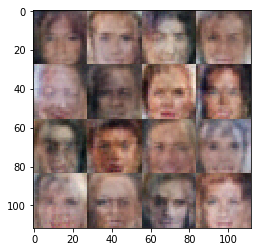

Epoch 0/0... Discriminator Loss: 0.9783... Generator Loss: 2.5058
Epoch 0/0... Discriminator Loss: 0.4647... Generator Loss: 3.2705
Epoch 0/0... Discriminator Loss: 0.9610... Generator Loss: 4.0729
Epoch 0/0... Discriminator Loss: 0.7373... Generator Loss: 1.8610
Epoch 0/0... Discriminator Loss: 0.6603... Generator Loss: 3.2863


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.